In [1]:
import backtrader as bt
import backtrader.indicator as btind
import backtrader.feeds as btfeeds

In [2]:
import pymssql
import pandas as pd
import numpy as np
import pyodbc
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
import os
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata
import datetime as dt

#導入數據
import math

#回測模塊
from datetime import datetime
import matplotlib.pyplot as plt
import binance

In [3]:
#下載歷史資料
client = binance.Client()      #先將API實例化方便取用

#撰寫幣安爬蟲API
def data_download(symbol, symbol_class, interval, start_str) :

    if symbol_class == 'spot' :
        klines = client.get_historical_klines(symbol, interval, start_str)
    if symbol_class == 'future' :
        klines = client.futures_historical_klines(symbol, interval, start_str)
    data = pd.DataFrame(klines)
    data.columns = ['open_time', 'open', 'high', 'low', 'close',
    'volume', 'close_time', 'qav', 'num_trades',
    'taker_base_vol', 'taker_base_vol', 'ignore']    
    data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
    data.index = data.index + dt.timedelta(seconds = 0.001)
    data.reset_index(inplace=True)
    data.set_index('index',inplace=True)
    data = data[['open','high','low','close','volume']]
    data['open'] = data['open'].astype(float)
    data['high'] = data['high'].astype(float)
    data['low'] = data['low'].astype(float)
    data['close'] = data['close'].astype(float)
    data['volume'] = data['volume'].astype(float)
    data["openinterest"] = 0
    return data    

In [4]:
#下載歷史資料 data1=期貨 , data2=現貨
data1 = data_download('BTCUSDT','future','30m','2020-01-01')
data2 = data_download('BTCUSDT','spot','30m','2020-01-01')

In [5]:
#用pd函數intersection取出交集，在將交集放入原始資料，使兩者長度相等
idx = data1.index.intersection(data2.index)
data1 = data1.loc[idx]
data2 = data2.loc[idx]

In [61]:
class difInd(bt.Indicator):
    lines = ('dif',)

    def next(self):
        self.lines.dif[0] = self.datas[0].close[0] - self.datas[1].close[0]


class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('rolling_window', 130),
        ('tp_ratio', 20),
        ('sl_ratio', 6),
        ('longout', 80),
        ('shortout', 120),

    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.lmt_1 = None
        self.lmt_2 = None
        

         # Add a MovingAverageSimple indicator
        self.dif = difInd(self.datas[0],self.datas[1])
        self.dif.plotinfo.plot = False
        self.spread_avg = (bt.ind.Highest(self.dif,period=self.params.rolling_window) - bt.ind.Lowest(self.dif,period=self.params.rolling_window))/2
        self.low = bt.ind.Lowest(self.datas[0].close,period = self.params.rolling_window)
        self.low.plotinfo.plot = False
        self.spot_hl = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) - self.low)/2
        self.spot_line = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) + self.low)/2
        self.datas[1].plotinfo.plot = False
        self.upper_band = self.spot_line + 0.3*(self.spot_hl+self.spread_avg)
        self.lower_band = self.spot_line - 0.2*(self.spot_hl+self.spread_avg)
        self.lowout = bt.ind.Lowest(self.datas[0].low,period=self.params.longout)
        self.lowout.plotinfo.plot = True
        self.lowout.plotinfo.subplot = False
        self.highout = bt.ind.Highest(self.datas[0].high,period =self.params.shortout)
        self.highout.plotinfo.plot = True
        self.highout.plotinfo.subplot = False
        

    def notify_order(self, order):
        type = "Buy" if order.isbuy() else "Sell"
        self.log(
            f"{order.data._name:<6} Order: {order.ref:3d}\tType: {type:<5}\tStatus"
            f" {order.getstatusname():<8} \t"
            f"Size: {order.created.size:9.4f} Create Price: {order.created.price:9.4f} "
            f"Position: {self.getposition(order.data).size}"
        )
        if order.status in [order.Submitted,order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            self.log(
                f"{order.data._name:<6} {('BUY' if order.isbuy() else 'SELL'):<5} "
                f"Price: {order.executed.price:6.2f} "
                f"Cost: {order.executed.value:6.2f} "
                f"Comm: {order.executed.comm:4.2f} "
                f"Size: {order.created.size:9.4f} "
            )

            if order.isbuy():
                self.buyprice = order.executed.price
                if self.position:
                    self.lmt_1 = self.sell(exectype= bt.Order.Limit, price = self.buyprice*(1+0.01*self.params.tp_ratio))
                    self.sell(exectype = bt.Order.Stop, price = self.buyprice*(1-0.01*self.params.sl_ratio),oco = self.lmt_1)
                    # self.sell(exectype = bt.Order.StopTrail, price = self.lowout[0],oco = self.lmt_1)

            elif order.issell():
                self.sellprice = order.executed.price
                if self.position:
                    self.lmt_2 = self.buy(exectype=bt.Order.Limit, price = self.sellprice*(1-0.01*self.params.tp_ratio))
                    self.buy(exectype=bt.Order.Stop, price= self.sellprice*(1+0.01*self.params.sl_ratio),oco = self.lmt_2)
                    # self.buy(exectype=bt.Order.StopTrail, price= self.highout[0],oco= self.lmt_2)
                
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            if (self.dataclose[-1] < self.upper_band[0]) & (self.dataclose[0] > self.upper_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                # BUY, BUY, BUY!!! (with all possible default parameters)
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(exectype= bt.Order.Limit,price = self.dataclose[0])


            elif (self.dataclose[-1] > self.lower_band[0]) & (self.dataclose[0] < self.lower_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                self.order = self.sell(exectype= bt.Order.Limit,price = self.dataclose[0])

        if self.position.size >0:
            print('lowout',self.lowout[0])
            if self.dataclose[0] <= self.lowout[0]:
                self.sell(oco = self.lmt_1)

        if self.position.size <0:
            print('highout',self.highout[0])
            if self.dataclose[0] >= self.highout[0]:
                self.buy(oco = self.lmt_2)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    params = dict(
            fromdate = dt.datetime(2020,1,1), # 回测开始时间
            todate = dt.datetime(2022,11,8),  # 回测结束时间
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0, # 下面几行是导入的数据，要和传入的数据列进行一一对应，以这个参数为准
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

    # Create a Data Feed
    datafeed1 = bt.feeds.PandasDirectData(dataname = data1, **params)
    datafeed2 = bt.feeds.PandasDirectData(dataname = data2, **params)

    # Add the Data Feed to Cerebro
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    

Starting Portfolio Value: 100000.00
2020-01-04T01:00:00, Close, 7383.00
2020-01-04T01:30:00, Close, 7358.60
2020-01-04T02:00:00, Close, 7352.90
2020-01-04T02:30:00, Close, 7346.35
2020-01-04T03:00:00, Close, 7340.42
2020-01-04T03:30:00, Close, 7329.94
2020-01-04T04:00:00, Close, 7338.90
2020-01-04T04:30:00, Close, 7320.45
2020-01-04T05:00:00, Close, 7315.05
2020-01-04T05:30:00, Close, 7323.00
2020-01-04T06:00:00, Close, 7277.27
2020-01-04T06:30:00, Close, 7268.95
2020-01-04T07:00:00, Close, 7296.78
2020-01-04T07:30:00, Close, 7333.01
2020-01-04T08:00:00, Close, 7341.72
2020-01-04T08:30:00, Close, 7312.96
2020-01-04T09:00:00, Close, 7302.87
2020-01-04T09:30:00, Close, 7299.03
2020-01-04T10:00:00, Close, 7305.22
2020-01-04T10:30:00, Close, 7301.38
2020-01-04T11:00:00, Close, 7324.13
2020-01-04T11:30:00, Close, 7317.05
2020-01-04T12:00:00, Close, 7329.29
2020-01-04T12:30:00, Close, 7322.80
2020-01-04T13:00:00, Close, 7330.28
2020-01-04T13:30:00, Close, 7342.27
2020-01-04T14:00:00, Close, 

<IPython.core.display.Javascript object>

[[<Figure size 2160x1440 with 4 Axes>]]

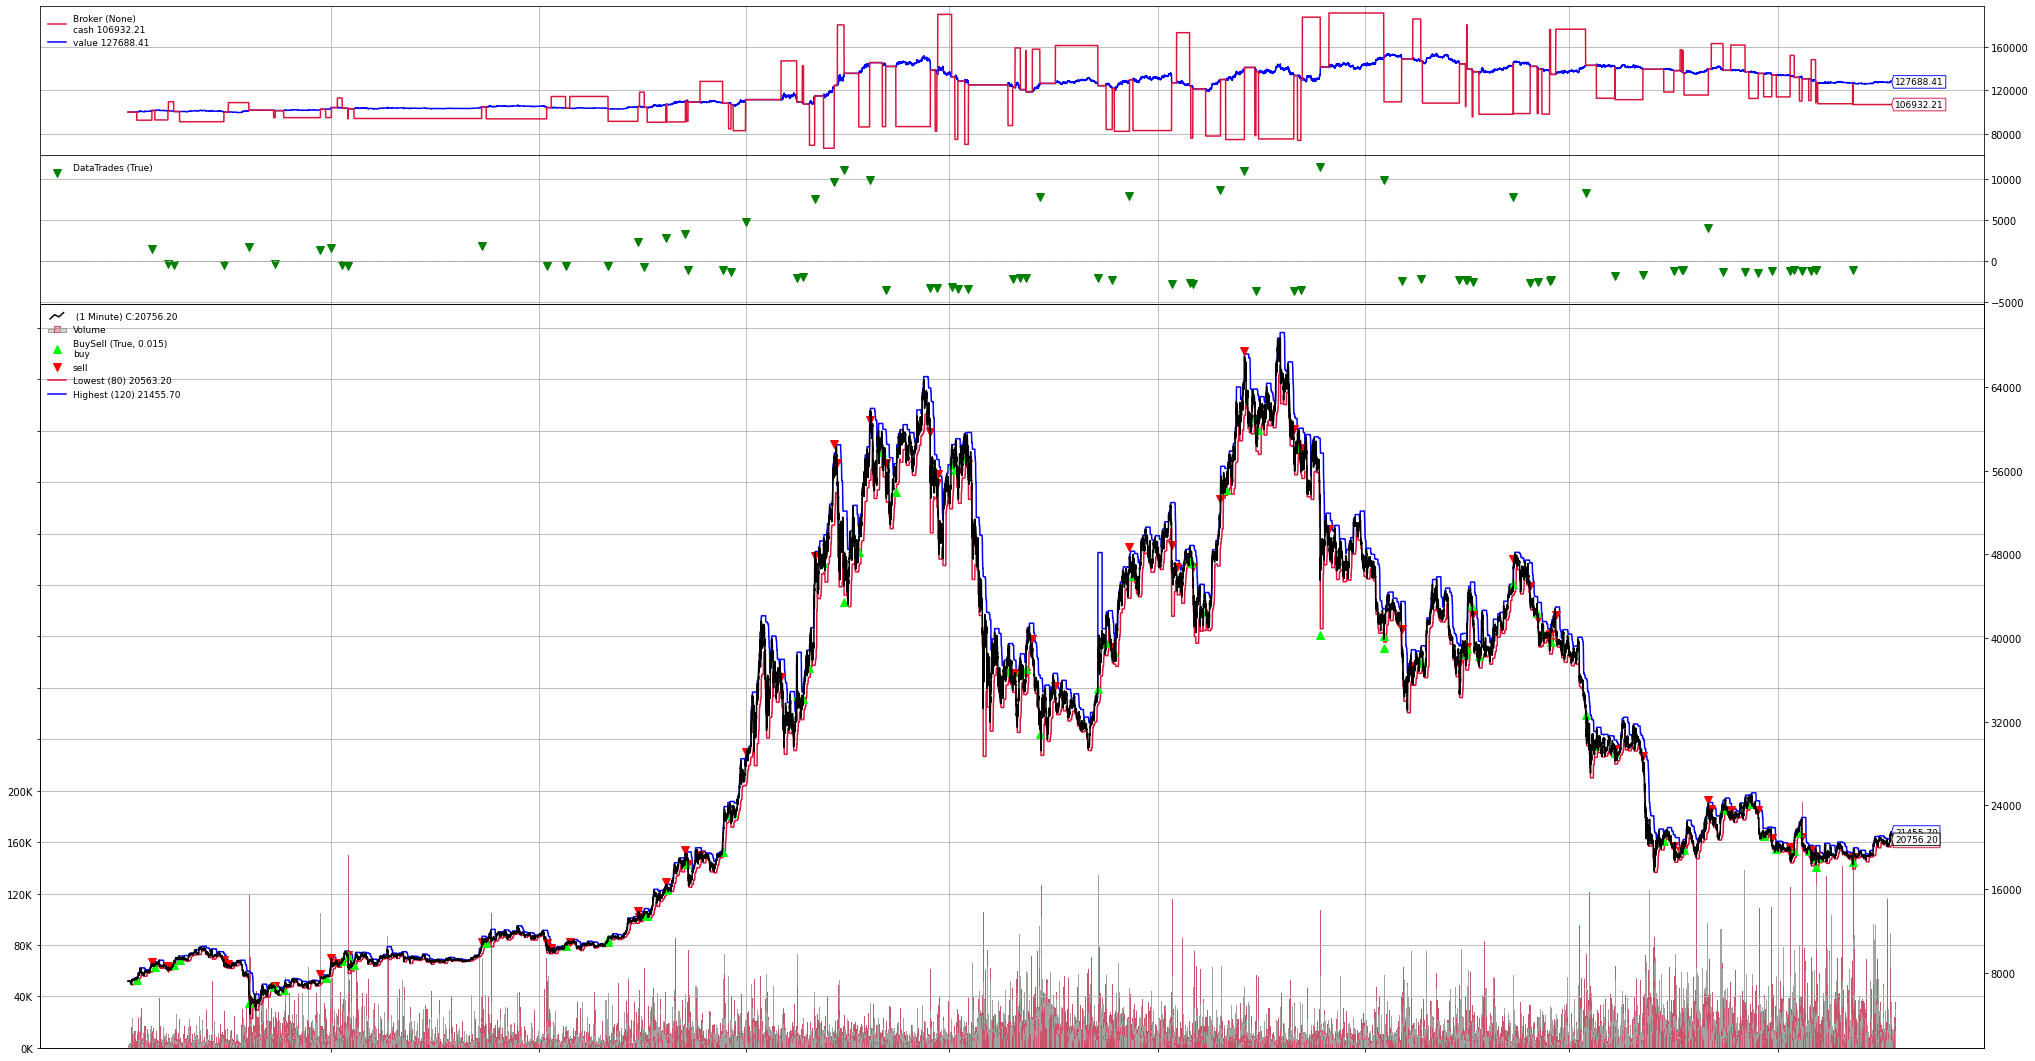

In [59]:
cerebro.plot()

In [25]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session

In [32]:
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [7]:
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

         # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    params = dict(
            fromdate = dt.datetime(2022,11,1), # 回测开始时间
            todate = dt.datetime(2022,11,8),  # 回测结束时间
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0, # 下面几行是导入的数据，要和传入的数据列进行一一对应，以这个参数为准
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

    # Create a Data Feed
    datafeed1 = bt.feeds.PandasDirectData(dataname = data1, **params)
    datafeed2 = bt.feeds.PandasDirectData(dataname = data2, **params)

    # Add the Data Feed to Cerebro
    cerebro.adddata(datafeed1)

    # Set our desired cash start
    cerebro.broker.setcash(1000000000000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000000000.00
2022-11-01T07:00:00, Close, 20467.30
2022-11-01T07:00:00, BUY CREATE, 20467.30
2022-11-01T07:30:00, BUY EXECUTED, Price: 20467.40, Cost: 204674.00, Comm 204.67
2022-11-01T07:30:00, Close, 20474.00
2022-11-01T08:00:00, Close, 20482.00
2022-11-01T08:30:00, Close, 20445.50
2022-11-01T09:00:00, Close, 20445.40
2022-11-01T09:30:00, Close, 20510.30
2022-11-01T10:00:00, Close, 20502.00
2022-11-01T10:30:00, Close, 20496.40
2022-11-01T11:00:00, Close, 20568.10
2022-11-01T11:30:00, Close, 20487.70
2022-11-01T12:00:00, Close, 20471.30
2022-11-01T12:30:00, Close, 20471.70
2022-11-01T13:00:00, Close, 20484.30
2022-11-01T13:30:00, Close, 20501.10
2022-11-01T14:00:00, Close, 20519.00
2022-11-01T14:30:00, Close, 20606.50
2022-11-01T15:00:00, Close, 20616.90
2022-11-01T15:30:00, Close, 20555.50
2022-11-01T16:00:00, Close, 20590.20
2022-11-01T16:30:00, Close, 20583.40
2022-11-01T17:00:00, Close, 20572.90
2022-11-01T17:30:00, Close, 20556.30
2022-11-01T18:00:00,

In [194]:
cerebro.addstrategy(TestStrategy)

0

In [195]:
rasilt = cerebro.run()

array('d')


In [134]:
cerebro.datas[0].datetime.time(0)

datetime.time(0, 0)